In [7]:
from types import SimpleNamespace

args = {
    "sst_train": "data/ids-sst-train.csv",
    "sst_dev": "data/ids-sst-dev.csv",
    "sst_test": "data/ids-sst-test-student.csv",
    "para_train": "data/quora-train.csv",
    "para_dev": "data/quora-dev.csv",
    "para_test": "data/quora-test-student.csv",
    "sts_train": "data/sts-train.csv",
    "sts_dev": "data/sts-dev.csv",
    "sts_test": "data/sts-test-student.csv",
    "seed": 11711,
    "epochs": 10,
    "fine-tune-mode": "last-linear-layer",
    "use_gpu": "store_true",
    "sst_dev_out": "predictions/sst-dev-output.csv",
    "sst_test_out": "predictions/sst-test-output.csv",
    "para_dev_out": "predictions/para-dev-output.csv",
    "para_test_out": "predictions/para-test-output.csv",
    "sts_dev_out": "predictions/sts-dev-output.csv",
    "sts_test_out": "predictions/sts-test-output.csv",
    "batch_size": 16,
    "hidden_dropout_prob": 0.3,
    "lr": 1e-5,
}
args = SimpleNamespace(**args)

In [8]:
from datasets import (
    SentenceClassificationDataset,
    SentenceClassificationTestDataset,
    SentencePairDataset,
    SentencePairTestDataset,
    load_multitask_data,
)
from torch.utils.data import DataLoader


sst_train_path = "data/ids-sst-train.csv"
para_train_path = "data/quora-train.csv"
sts_train_path = "data/sts-train.csv"
sst_train_data, num_labels, para_train_data, sts_train_data = load_multitask_data(
    sst_train_path, para_train_path, sts_train_path, split="train"
)

Loaded 8544 train examples from data/ids-sst-train.csv
Loaded 283003 train examples from data/quora-train.csv
Loaded 6040 train examples from data/sts-train.csv


In [9]:
sst_train_data = SentenceClassificationDataset(sst_train_data, args)
sst_train_dataloader = DataLoader(
    sst_train_data,
    shuffle=True,
    batch_size=args.batch_size,
    collate_fn=sst_train_data.collate_fn,
)
para_train_data = SentencePairDataset(para_train_data, args)
para_train_dataloader = DataLoader(
    para_train_data,
    shuffle=True,
    batch_size=args.batch_size,
    collate_fn=para_train_data.collate_fn,
)
sts_train_data = SentencePairDataset(sts_train_data, args)
sts_train_dataloader = DataLoader(
    sts_train_data,
    shuffle=True,
    batch_size=args.batch_size,
    collate_fn=sts_train_data.collate_fn,
)

In [13]:
len(sts_train_dataloader)

378

In [3]:
from multitask_classifier import MultitaskBERT
# Init model.
config = {
    "hidden_dropout_prob": 0.3,
    "num_labels": 3,
    "hidden_size": 768,
    "data_dir": ".",
    "fine_tune_mode": 'full-model',
}

config = SimpleNamespace(**config)

model = MultitaskBERT(config)
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")


bert.word_embedding.weight: torch.Size([30522, 768])
bert.pos_embedding.weight: torch.Size([512, 768])
bert.tk_type_embedding.weight: torch.Size([2, 768])
bert.embed_layer_norm.weight: torch.Size([768])
bert.embed_layer_norm.bias: torch.Size([768])
bert.bert_layers.0.self_attention.query.weight: torch.Size([768, 768])
bert.bert_layers.0.self_attention.query.bias: torch.Size([768])
bert.bert_layers.0.self_attention.key.weight: torch.Size([768, 768])
bert.bert_layers.0.self_attention.key.bias: torch.Size([768])
bert.bert_layers.0.self_attention.value.weight: torch.Size([768, 768])
bert.bert_layers.0.self_attention.value.bias: torch.Size([768])
bert.bert_layers.0.attention_dense.weight: torch.Size([768, 768])
bert.bert_layers.0.attention_dense.bias: torch.Size([768])
bert.bert_layers.0.attention_layer_norm.weight: torch.Size([768])
bert.bert_layers.0.attention_layer_norm.bias: torch.Size([768])
bert.bert_layers.0.interm_dense.weight: torch.Size([3072, 768])
bert.bert_layers.0.interm_dense

In [18]:
import time
import torch
a = torch.randn((768,768))
b = torch.randn((768,768))
t = time.time()
d = torch.diag(a@b.T)
print(f"{time.time() - t}")
t = time.time()
d = torch.bmm(a.unsqueeze(1),b.unsqueeze(-1)).flatten()
print(f"{time.time() - t}")

cflct_idx = torch.nonzero(d<0, as_tuple=True)[0]
gradi, gradj = a, b
csim = d
m = csim[cflct_idx]/(torch.linalg.vector_norm(gradj[cflct_idx,],ord=2)**2)
gradi[cflct_idx,] = gradi[cflct_idx,] - gradj[cflct_idx,]/m.unsqueeze(-1)


0.002653837203979492
0.00029659271240234375
torch.Size([393])


In [32]:
a = [None,None]
b = [k for k,aa in enumerate(a) if isinstance(aa, int)]
print(b)

[]


In [25]:
import torch
l1 = torch.nn.Linear(10,2)
l2 = torch.nn.Linear(10,3)
a = torch.randn(3,10)
b = torch.randn(3,10)
c = torch.randn(3,2)
d = torch.randn(3,3)
cp = l1(a)
dp = l2(b)
loss1 = torch.nn.functional.mse_loss(cp, c,reduction="mean")
loss2 = torch.nn.functional.mse_loss(dp,d,reduction="mean")
loss = torch.stack((loss1, loss2),dim=0)
# loss1.backward()
# loss2.backward()
sloss = torch.sum(loss)
sloss.backward()

In [26]:
for name,param in l1.named_parameters():
    print(f"{name} grad = {param.grad}")
for name,param in l2.named_parameters():
    print(f"{name} grad = {param.grad}")

weight grad = tensor([[-0.5569, -0.0263, -0.5904, -0.2771, -0.5700,  0.3826,  1.6349, -0.6649,
         -0.0971, -1.3702],
        [ 0.0989,  2.2668,  0.3431,  2.2672, -0.0566, -1.7436, -3.5019,  0.1796,
         -1.5225,  2.9598]])
bias grad = tensor([ 0.4695, -0.1576])
weight grad = tensor([[-0.1889, -0.2602,  0.0242, -0.3457,  0.8896, -0.4121, -0.0778,  0.5638,
          0.4857,  0.2158],
        [-0.1767, -0.5806,  0.0578,  0.0602,  0.8510, -0.5595,  0.2778,  0.7785,
          0.6469,  0.0253],
        [-0.2446, -1.0186,  0.2515,  0.5808,  0.3606, -0.3409, -0.1084,  0.0341,
          0.2340,  0.0353]])
bias grad = tensor([-0.0049, -0.3456, -0.4659])


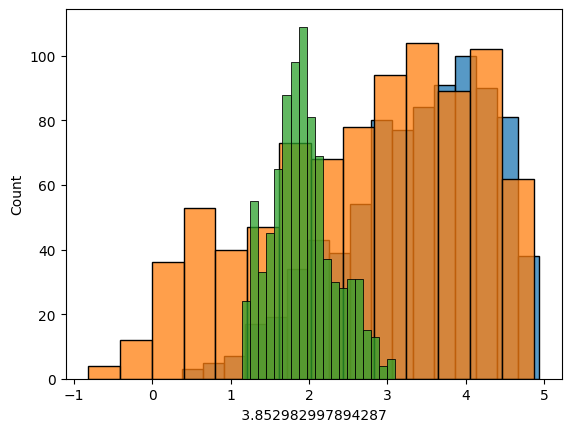

In [19]:
import pandas as pd
import seaborn as ses

sts_pred1 = pd.read_csv('./predictions/sts_experiment/1_sts-dev-output.csv',header=1)
f1 = ses.histplot(sts_pred1.iloc[:,1])

sts_pred2 = pd.read_csv('./predictions/single_task_model/single_sts/sts-dev-output.csv',header=1)
f2 = ses.histplot(sts_pred2.iloc[:,1]*5)

sts_pred3 = pd.read_csv('./predictions/old/multi_pretrain_sts_fullmdl/sts-dev-output.csv',header=1)
f2 = ses.histplot(sts_pred3.iloc[:,1])